# Messy/Clean Room Classification

### Importing Libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

### Getting our Data

In [ ]:
# setting up the drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
directory = '/content/drive/My Drive/Room Classification/Dataset/'

train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=42)

validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=42)

Found 192 files belonging to 2 classes.
Using 154 files for training.
Found 192 files belonging to 2 classes.
Using 38 files for validation.


### Augmenting and Preprocessing the Data

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
def data_augmenter():
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip('horizontal'))
    data_augmentation.add(RandomRotation(0.2))
    
    return data_augmentation

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

### Building and Training the Model

In [ ]:
def room(image_shape=IMG_SIZE, data_augmentation=data_augmenter(), fine_tune_at=120):
    input_shape = image_shape + (3,)
    
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False,
                                                   weights='imagenet')

    base_model.trainable = True
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False

    inputs = tf.keras.Input(shape=input_shape) 
    x = data_augmentation(inputs)
    x = preprocess_input(x) 

    x = base_model(x, training=False) 

    x = tfl.GlobalAveragePooling2D()(x) 
    x = tfl.Dropout(0.2)(x)

    prediction_layer = tfl.Dense(1)
    
    outputs = prediction_layer(x) 
    model = tf.keras.Model(inputs, outputs)
    
    return model

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SIZE + (3,),
                                                   include_top=False,
                                                   weights='imagenet')
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


In [ ]:
learning_rate = 0.0001
fine_tune_at = 120
epochs = 10
data_augmentation = data_augmenter()

In [ ]:
# training the model
model = room(IMG_SIZE, data_augmentation, fine_tune_at)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

model_train = model.fit(train_dataset, validation_data=validation_dataset, epochs=epochs)

Epoch 1/10
5/5 [==============================] - 9s 1s/step - loss: 0.5821 - accuracy: 0.6818 - val_loss: 0.3248 - val_accuracy: 0.7632
Epoch 2/10
5/5 [==============================] - 5s 925ms/step - loss: 0.1800 - accuracy: 0.9481 - val_loss: 0.1604 - val_accuracy: 0.8947
Epoch 3/10
5/5 [==============================] - 5s 943ms/step - loss: 0.1467 - accuracy: 0.9545 - val_loss: 0.1665 - val_accuracy: 0.8947
Epoch 4/10
5/5 [==============================] - 5s 916ms/step - loss: 0.0597 - accuracy: 0.9805 - val_loss: 0.1773 - val_accuracy: 0.9211
Epoch 5/10
5/5 [==============================] - 5s 945ms/step - loss: 0.0690 - accuracy: 0.9805 - val_loss: 0.3423 - val_accuracy: 0.8421
Epoch 6/10
5/5 [==============================] - 5s 934ms/step - loss: 0.0674 - accuracy: 0.9805 - val_loss: 0.0555 - val_accuracy: 0.9737
Epoch 7/10
5/5 [==============================] - 5s 926ms/step - loss: 0.1058 - accuracy: 0.9610 - val_loss: 0.0585 - val_accuracy: 0.9737
Epoch 8/10
5/5 [=======

### Plotting the Results

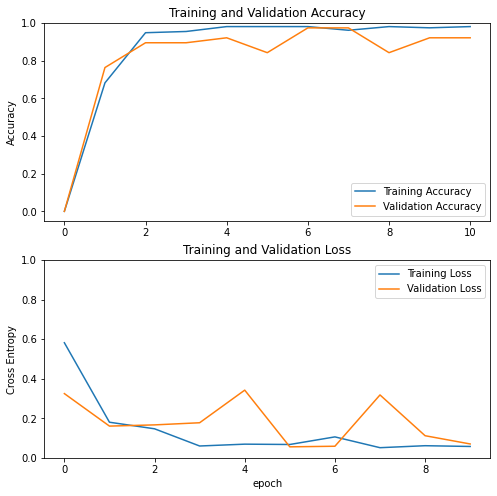

In [ ]:
acc = [0.] + model_train.history['accuracy']
val_acc = [0.] + model_train.history['val_accuracy']

loss = model_train.history['loss']
val_loss = model_train.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Making Predictions

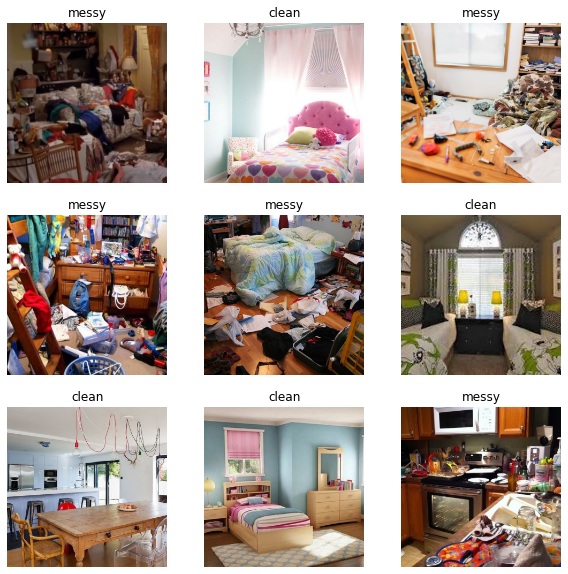

In [ ]:
class_names = validation_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in validation_dataset.take(1):
    image_var = tf.Variable(images)
    pred = model.predict(images)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
         
        plt.title(class_names[labels[i]])
        plt.axis("off")